In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import pickle
import random
from collections import defaultdict, deque
import itertools

# Part 1: Data Collection and Preprocessing
class PokerHandDataset:
    def __init__(self, data_path=None):
        self.data_path = data_path
        self.data = None
        self.features = None
        self.labels = None
    
    def load_data(self, data_path=None):
        """Load poker hand data from UCI Machine Learning Repository"""
        if data_path is not None:
            self.data_path = data_path
        
        if self.data_path is None:
            # Default to UCI Poker Hand dataset if no path provided
            self.data_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data"
            print(f"No data path provided. Using UCI Poker Hand dataset: {self.data_path}")
        
        try:
            # UCI Poker Hand dataset has no header, so we provide column names
            column_names = [
                'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 
                'hand_class'
            ]
            
            self.data = pd.read_csv(self.data_path, header=None, names=column_names)
            print(f"Loaded {len(self.data)} poker hands from {self.data_path}")
            
            # Convert UCI format to our expected format
            self.convert_uci_format()
            return
        except Exception as e:
            print(f"Error loading data: {e}")
            raise ValueError("Failed to load UCI Poker Hand dataset.")
    
    def convert_uci_format(self):
        """Convert UCI Poker Hand dataset format to our expected format"""
        # In UCI dataset:
        # Suit: 1=Hearts, 2=Spades, 3=Diamonds, 4=Clubs
        # Rank: 1=Ace, 2-10=Number cards, 11=Jack, 12=Queen, 13=King
        
        suit_map = {1: 'h', 2: 's', 3: 'd', 4: 'c'}
        # Note: UCI uses 1 for Ace, but our code expects 14
        rank_map = {1: 'A', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 
                   8: '8', 9: '9', 10: 'T', 11: 'J', 12: 'Q', 13: 'K'}
        
        # Create a new DataFrame for our format
        new_data = pd.DataFrame()
        
        # Convert the 5 cards to our format
        for i in range(1, 6):
            suit = self.data[f'S{i}'].map(suit_map)
            rank = self.data[f'C{i}'].map(rank_map)
            card = rank + suit
            
            if i <= 2:
                # First two cards are hole cards
                new_data[f'hole_card_{i}'] = card
            else:
                # Remaining three are community cards
                new_data[f'community_card_{i-2}'] = card
        
        # Add two more community cards (randomly generated)
        # since UCI dataset has 5 cards but our code expects 7 (2 hole + 5 community)
        suits = ['h', 'd', 'c', 's']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
        
        def generate_random_card():
            return random.choice(ranks) + random.choice(suits)
        
        new_data['community_card_4'] = [generate_random_card() for _ in range(len(self.data))]
        new_data['community_card_5'] = [generate_random_card() for _ in range(len(self.data))]
        
        # Generate reasonable values for other fields
        positions = ['SB', 'BB', 'UTG', 'MP', 'CO', 'BTN']
        actions = ['check', 'bet_small', 'bet_medium', 'bet_large', 'raise', 'all_in']
        
        new_data['position'] = [random.choice(positions) for _ in range(len(self.data))]
        new_data['players_left'] = [random.randint(1, 5) for _ in range(len(self.data))]
        new_data['pot_size'] = [random.randint(5, 100) for _ in range(len(self.data))]
        new_data['stack_size'] = [random.randint(50, 1000) for _ in range(len(self.data))]
        
        for action in ['preflop_action', 'flop_action', 'turn_action', 'river_action']:
            new_data[action] = [random.choice(actions) for _ in range(len(self.data))]
        
        # Use hand_class as outcome (we'll simplify to binary: winning/losing hand)
        # In UCI dataset: 0=Nothing, 1=One pair, ..., 9=Royal flush
        # We'll consider hands with class >= 1 as "winning" (1) and 0 as "losing" (0)
        new_data['outcome'] = (self.data['hand_class'] >= 1).astype(int)
        
        self.data = new_data
        print("Successfully converted UCI Poker Hand dataset to required format")
    
    def preprocess_data(self):
        """Convert poker hand data into ML-ready features"""
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        # Convert card representations to numerical features
        df = self.data.copy()
        
        # Create feature columns
        feat_df = pd.DataFrame()
        
        # Convert hole cards to numerical features
        for i, col in enumerate(['hole_card_1', 'hole_card_2']):
            feat_df[f'hole_rank_{i+1}'] = df[col].str[0].map({
                '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 
                '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14
            })
            feat_df[f'hole_suit_{i+1}'] = df[col].str[1].map({'h': 0, 'd': 1, 'c': 2, 's': 3})
        
        # Add feature: are hole cards suited?
        feat_df['hole_suited'] = (feat_df['hole_suit_1'] == feat_df['hole_suit_2']).astype(int)
        
        # Add feature: hole cards pair?
        feat_df['hole_pair'] = (feat_df['hole_rank_1'] == feat_df['hole_rank_2']).astype(int)
        
        # Add feature: hole cards strength (sum of ranks)
        feat_df['hole_strength'] = feat_df['hole_rank_1'] + feat_df['hole_rank_2']
        
        # Convert community cards to numerical features
        for i, col in enumerate(['community_card_1', 'community_card_2', 'community_card_3', 
                               'community_card_4', 'community_card_5']):
            feat_df[f'comm_rank_{i+1}'] = df[col].str[0].map({
                '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 
                '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14
            })
            feat_df[f'comm_suit_{i+1}'] = df[col].str[1].map({'h': 0, 'd': 1, 'c': 2, 's': 3})
        
        # One-hot encode position
        position_dummies = pd.get_dummies(df['position'], prefix='pos')
        feat_df = pd.concat([feat_df, position_dummies], axis=1)
        
        # Include other numerical features
        feat_df['players_left'] = df['players_left']
        feat_df['pot_size'] = df['pot_size']
        feat_df['stack_size'] = df['stack_size']
        
        # Convert actions to numerical values
        action_map = {
            'check': 0,
            'bet_small': 1,
            'bet_medium': 2,
            'bet_large': 3,
            'raise': 4,
            'all_in': 5
        }
        
        for action in ['preflop_action', 'flop_action', 'turn_action', 'river_action']:
            feat_df[action] = df[action].map(action_map)
        
        # Save features and labels
        self.labels = df['outcome'].values
        self.features = feat_df.values
        
        return feat_df, df['outcome']

In [12]:
# Part 2: Hand Evaluation Functions
class PokerHandEvaluator:
    def __init__(self):
        self.hand_rankings = {
            'high_card': 1,
            'pair': 2,
            'two_pair': 3,
            'three_of_a_kind': 4,
            'straight': 5,
            'flush': 6,
            'full_house': 7,
            'four_of_a_kind': 8,
            'straight_flush': 9
        }
    
    def evaluate_hand(self, hole_cards, community_cards):
        """Evaluate a poker hand and return its rank"""
        all_cards = hole_cards + community_cards
        
        # Extract ranks and suits
        ranks = [card[0] for card in all_cards]
        suits = [card[1] for card in all_cards]
        
        # Convert letter ranks to numbers
        rank_values = []
        for r in ranks:
            if r == 'T':
                rank_values.append(10)
            elif r == 'J':
                rank_values.append(11)
            elif r == 'Q':
                rank_values.append(12)
            elif r == 'K':
                rank_values.append(13)
            elif r == 'A':
                rank_values.append(14)
            else:
                rank_values.append(int(r))
        
        # Count rank frequencies
        rank_counts = defaultdict(int)
        for r in rank_values:
            rank_counts[r] += 1
        
        # Count suit frequencies
        suit_counts = defaultdict(int)
        for s in suits:
            suit_counts[s] += 1
        
        # Check for flush
        flush = any(count >= 5 for count in suit_counts.values())
        
        # Check for straight
        unique_ranks = sorted(set(rank_values))
        straight = False
        for i in range(len(unique_ranks) - 4):
            if unique_ranks[i:i+5] == list(range(unique_ranks[i], unique_ranks[i] + 5)):
                straight = True
                break
        
        # Special case: A-5 straight
        if set([2, 3, 4, 5, 14]).issubset(set(rank_values)):
            straight = True
        
        # Find hand rank
        if straight and flush:
            return self.hand_rankings['straight_flush']
        elif 4 in rank_counts.values():
            return self.hand_rankings['four_of_a_kind']
        elif 3 in rank_counts.values() and 2 in rank_counts.values():
            return self.hand_rankings['full_house']
        elif flush:
            return self.hand_rankings['flush']
        elif straight:
            return self.hand_rankings['straight']
        elif 3 in rank_counts.values():
            return self.hand_rankings['three_of_a_kind']
        elif list(rank_counts.values()).count(2) >= 2:
            return self.hand_rankings['two_pair']
        elif 2 in rank_counts.values():
            return self.hand_rankings['pair']
        else:
            return self.hand_rankings['high_card']

In [13]:
# Part 3: Random Forest Model
class RandomForestPokerModel:
    def __init__(self, n_estimators=100, random_state=42):
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1
        )
        self.feature_importance = None
    
    def train(self, X_train, y_train):
        """Train the random forest model on poker hand data"""
        print("Training Random Forest model...")
        self.model.fit(X_train, y_train)
        self.feature_importance = self.model.feature_importances_
        return self.model
    
    def predict(self, X):
        """Predict optimal action for a poker hand"""
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Predict probability of winning with a poker hand"""
        return self.model.predict_proba(X)
    
    def evaluate(self, X_test, y_test):
        """Evaluate the model performance"""
        y_pred = self.model.predict(X_test)
        print("\nRandom Forest Model Evaluation:")
        print(classification_report(y_test, y_pred))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        return cm
    
    def save_model(self, filepath):
        """Save the trained model to disk"""
        with open(filepath, 'wb') as f:
            pickle.dump(self.model, f)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model from disk"""
        with open(filepath, 'rb') as f:
            self.model = pickle.load(f)
        print(f"Model loaded from {filepath}")
        return self.model
    
    def plot_feature_importance(self, feature_names):
        """Plot feature importance from the random forest model"""
        if self.feature_importance is None:
            raise ValueError("Model has not been trained yet")
        
        # Get feature importance
        importance = self.feature_importance
        
        # Create DataFrame for plotting
        feat_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
        plt.title('Random Forest Feature Importance')
        plt.tight_layout()
        return feat_imp_df



In [14]:
# Part 4: Neural Network Model
class NeuralNetworkPokerModel:
    def __init__(self, input_dim):
        self.model = self._build_model(input_dim)
    
    def _build_model(self, input_dim):
        """Build the neural network architecture"""
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_dim,)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        """Train the neural network model"""
        print("Training Neural Network model...")
        
        validation_data = None
        if X_val is not None and y_val is not None:
            validation_data = (X_val, y_val)
        
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            verbose=1
        )
        
        return history
    
    def predict(self, X):
        """Predict optimal action for a poker hand"""
        predictions = self.model.predict(X)
        return (predictions > 0.5).astype('int')
    
    def predict_proba(self, X):
        """Predict probability of winning with a poker hand"""
        return self.model.predict(X)
    
    def evaluate(self, X_test, y_test):
        """Evaluate the model performance"""
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"\nNeural Network Model Evaluation:")
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        
        y_pred = (self.predict_proba(X_test) > 0.5).astype('int').flatten()
        print(classification_report(y_test, y_pred))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        return cm
    
    def save_model(self, filepath):
        """Save the trained model"""
        self.model.save(filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model"""
        from tensorflow.keras.models import load_model
        self.model = load_model(filepath)
        print(f"Model loaded from {filepath}")
        return self.model
    
    def plot_training_history(self, history):
        """Plot the training history"""
        plt.figure(figsize=(12, 5))
        
        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'])
            plt.legend(['Train', 'Validation'], loc='lower right')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'])
            plt.legend(['Train', 'Validation'], loc='upper right')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        
        plt.tight_layout()
        plt.show()

In [15]:
# Part 5: Monte Carlo Simulation
class MonteCarloSimulator:
    def __init__(self, hand_evaluator):
        self.evaluator = hand_evaluator
        self.deck = None
    
    def _init_deck(self):
        """Initialize a standard deck of cards"""
        suits = ['h', 'd', 'c', 's']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
        self.deck = [r+s for r in ranks for s in suits]
    
    def _draw_cards(self, n, excluded_cards):
        """Draw n random cards from the deck excluding certain cards"""
        available_cards = [card for card in self.deck if card not in excluded_cards]
        return random.sample(available_cards, n)
    
    def simulate_hand(self, hole_cards, community_cards=None, n_opponents=1, n_simulations=1000):
        """
        Simulate n poker hands using Monte Carlo method and return win probability
        
        Args:
            hole_cards: List of two cards (e.g. ['Ah', 'Ks'])
            community_cards: List of community cards (0-5 cards)
            n_opponents: Number of opponents to simulate
            n_simulations: Number of simulations to run
            
        Returns:
            win_probability: Probability of winning
        """
        if community_cards is None:
            community_cards = []
        
        # Validate input
        if len(hole_cards) != 2:
            raise ValueError("Hole cards must contain exactly 2 cards")
        if len(community_cards) > 5:
            raise ValueError("Community cards can't exceed 5 cards")
        
        # Initialize deck
        self._init_deck()
        
        # Check if cards are valid
        all_input_cards = hole_cards + community_cards
        if not all(card in self.deck for card in all_input_cards):
            raise ValueError("Invalid card(s) provided")
        
        # Check if there are duplicate cards
        if len(all_input_cards) != len(set(all_input_cards)):
            raise ValueError("Duplicate cards provided")
        
        # Run simulations
        wins = 0
        ties = 0
        
        for _ in range(n_simulations):
            # Reset for this simulation
            remaining_community = 5 - len(community_cards)
            
            # Draw remaining community cards if needed
            sim_community = community_cards.copy()
            if remaining_community > 0:
                sim_community += self._draw_cards(remaining_community, all_input_cards)
            
            # Our hand strength
            our_strength = self.evaluator.evaluate_hand(hole_cards, sim_community)
            
            # Simulate opponents' hands
            opponent_strengths = []
            for _ in range(n_opponents):
                opponent_hole = self._draw_cards(2, all_input_cards + sim_community)
                opponent_strength = self.evaluator.evaluate_hand(opponent_hole, sim_community)
                opponent_strengths.append(opponent_strength)
            
            # Compare hand strengths
            if our_strength > max(opponent_strengths):
                wins += 1
            elif our_strength == max(opponent_strengths):
                ties += 1
        
        # Calculate win probability, counting ties as half-wins
        win_probability = (wins + (ties / 2)) / n_simulations
        
        return win_probability
    
    def calculate_ev(self, win_prob, pot_size, bet_size):
        """
        Calculate expected value of a bet
        
        Args:
            win_prob: Probability of winning
            pot_size: Current pot size
            bet_size: Size of the bet to make
            
        Returns:
            ev: Expected value of the bet
        """
        # EV = (win_prob * amount_won) - ((1 - win_prob) * amount_lost)
        ev = (win_prob * (pot_size + bet_size)) - ((1 - win_prob) * bet_size)
        return ev
    
    def optimal_bet_size(self, win_prob, pot_size, stack_size, min_bet, max_bet, steps=10):
        """
        Find the optimal bet size based on expected value
        
        Args:
            win_prob: Probability of winning
            pot_size: Current pot size
            stack_size: Player's remaining stack
            min_bet: Minimum possible bet
            max_bet: Maximum possible bet
            steps: Number of bet sizes to evaluate
            
        Returns:
            optimal_size: Bet size with highest expected value
            max_ev: Maximum expected value
        """
        max_bet = min(max_bet, stack_size)
        bet_range = np.linspace(min_bet, max_bet, steps)
        
        evs = [self.calculate_ev(win_prob, pot_size, bet) for bet in bet_range]
        max_ev_idx = np.argmax(evs)
        
        return bet_range[max_ev_idx], evs[max_ev_idx]

In [16]:
# Part 6: Game Theory and Bluffing Strategies
class GameTheoryAnalyzer:
    def __init__(self):
        self.bluff_frequencies = {}
    
    def calculate_optimal_bluffing_frequency(self, pot_size, bet_size):
        """
        Calculate optimal bluffing frequency based on pot odds
        
        Args:
            pot_size: Current pot size
            bet_size: Size of the bet
            
        Returns:
            bluff_freq: Optimal bluffing frequency
        """
        # Based on game theory, optimal bluffing frequency = bet_size / (bet_size + pot_size)
        # This is derived from making opponent indifferent between calling and folding
        bluff_freq = bet_size / (bet_size + pot_size)
        return bluff_freq
    
    def should_bluff(self, hand_strength, bluff_threshold=0.3):
        """Decide whether to bluff based on hand strength and threshold"""
        return hand_strength < bluff_threshold
    
    def calculate_optimal_defense_frequency(self, bet_size, pot_size):
        """
        Calculate optimal defense frequency against bets
        
        Args:
            bet_size: Size of the opponent's bet
            pot_size: Current pot size
            
        Returns:
            defense_freq: Optimal calling frequency
        """
        # Based on pot odds, optimal defense frequency = pot_size / (pot_size + bet_size)
        defense_freq = pot_size / (pot_size + bet_size)
        return defense_freq
    
    def calculate_mrm_exploitative_strategy(self, opponent_folding_freq, pot_size, bet_size):
        """
        Calculate maximally exploitative strategy based on opponent tendencies
        
        Args:
            opponent_folding_freq: Frequency at which opponent folds to bets
            pot_size: Current pot size
            bet_size: Size of the bet
            
        Returns:
            bluff_all: Whether to bluff with all hands
            value_bet_all: Whether to value bet with all hands
        """
        # Calculate EV of bluffing
        ev_bluff = (opponent_folding_freq * pot_size) - ((1 - opponent_folding_freq) * bet_size)
        
        # If EV of bluffing is positive, we should bluff with all hands that can't win at showdown
        bluff_all = ev_bluff > 0
        
        # We should value bet with all hands that can win at showdown
        value_bet_all = True
        
        return bluff_all, value_bet_all
    
    def analyze_bluffing_spots(self, position, n_players, community_cards_count, pot_odds):
        """
        Analyze whether a spot is good for bluffing based on various factors
        
        Args:
            position: Player's position ('SB', 'BB', 'UTG', 'MP', 'CO', 'BTN')
            n_players: Number of players in the hand
            community_cards_count: Number of community cards (0=preflop, 3=flop, 4=turn, 5=river)
            pot_odds: Current pot odds
            
        Returns:
            bluff_score: Score indicating how good the spot is for bluffing (0-1)
            recommendations: List of recommendations
        """
        bluff_score = 0
        recommendations = []
        
        # Adjust based on position
        position_scores = {
            'BTN': 1.0,   # Button is best position for bluffing
            'CO': 0.9,    # Cutoff is good
            'MP': 0.7,    # Middle position
            'UTG': 0.4,   # Under the gun is bad for bluffing
            'SB': 0.6,    # Small blind
            'BB': 0.5     # Big blind
        }
        
        position_score = position_scores.get(position, 0.5)
        bluff_score += position_score * 0.3  # Position is 30% of the bluff score
        
        if position in ['BTN', 'CO']:
            recommendations.append("Good position for bluffing")
        elif position in ['UTG']:
            recommendations.append("Poor position for bluffing")
        
        # Adjust based on number of players
        player_factor = 1.0 - (n_players / 6.0)  # Fewer players is better for bluffing
        bluff_score += player_factor * 0.2  # Number of players is 20% of bluff score
        
        if n_players <= 2:
            recommendations.append("Heads-up is good for bluffing")
        elif n_players >= 4:
            recommendations.append("Too many players to bluff effectively")
        
        # Adjust based on street
        street_scores = {
            0: 0.5,  # Preflop
            3: 0.7,  # Flop
            4: 0.8,  # Turn
            5: 0.9   # River
        }
        
        street_score = street_scores.get(community_cards_count, 0.5)
        bluff_score += street_score * 0.2  # Street is 20% of bluff score
        
        if community_cards_count == 5:
            recommendations.append("River is a good street for bluffing as opponent must have a hand")
        
        # Adjust based on pot odds
        if pot_odds < 0.2:
            bluff_score += 0.3  # Small pot odds are good for bluffing
            recommendations.append("Low pot odds make this a good bluffing opportunity")
        elif pot_odds > 0.4:
            bluff_score -= 0.1  # Large pot odds are bad for bluffing
            recommendations.append("High pot odds reduce effectiveness of bluffing")
        
        # Normalize final score
        bluff_score = max(0, min(1, bluff_score))
        
        return bluff_score, recommendations

In [17]:
# NEW PART: Deep Counterfactual Regret Minimization
class DeepCFR:
    def __init__(self, input_dim, action_dim=6, model_layers=[128, 64], memory_size=10000, gamma=0.95):
        """
        Initialize Deep CFR model
        
        Args:
            input_dim: Dimension of the input state
            action_dim: Number of possible actions
            model_layers: Hidden layer sizes for the advantage networks
            memory_size: Size of the replay buffer
            gamma: Discount factor for future regrets
        """
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.model_layers = model_layers
        self.memory_size = memory_size
        self.gamma = gamma
        
        # Build advantage networks for each player (0 = hero, 1 = villain)
        self.advantage_networks = {}
        self.target_networks = {}
        for player in [0, 1]:
            self.advantage_networks[player] = self._build_advantage_network()
            self.target_networks[player] = self._build_advantage_network()
            # Copy weights from advantage to target network
            self.target_networks[player].set_weights(self.advantage_networks[player].get_weights())
        
        # Replay buffers for each player
        self.replay_buffers = {
            0: deque(maxlen=memory_size),
            1: deque(maxlen=memory_size)
        }
        
        # Strategy profile
        self.strategy_profile = {}
    
    def _build_advantage_network(self):
        """Build neural network for advantage function approximation"""
        inputs = Input(shape=(self.input_dim,))
        x = inputs
        
        # Hidden layers
        for layer_size in self.model_layers:
            x = Dense(layer_size, activation='relu')(x)
            x = Dropout(0.3)(x)
        
        # Output layer - one node per action
        advantages = Dense(self.action_dim, activation='linear')(x)
        
        model = Model(inputs=inputs, outputs=advantages)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        return model
    
    def _state_to_features(self, state):
        """Convert game state to feature vector"""
        # In a real implementation, this would convert the poker game state
        # (cards, positions, etc.) into a numerical feature vector
        # Here we just assume the state is already a feature vector
        return np.array(state).reshape(1, -1)
    
    def _compute_strategy(self, advantages):
        """Compute strategy from advantage values using regret matching"""
        # Clip negative regrets to zero (regret matching)
        positive_advantages = np.maximum(advantages, 0)
        
        # If all regrets are negative or zero, use uniform strategy
        if np.sum(positive_advantages) <= 0:
            return np.ones(self.action_dim) / self.action_dim
        
        # Normalize to get valid probability distribution
        strategy = positive_advantages / np.sum(positive_advantages)
        return strategy
    
    def get_strategy(self, state, player=0):
        """Get strategy (action probabilities) for a given state"""
        # Convert state to features
        features = self._state_to_features(state)
        
        # Get advantage values from the network
        advantages = self.advantage_networks[player].predict(features, verbose=0)[0]
        
        # Compute strategy from advantages
        strategy = self._compute_strategy(advantages)
        
        # Store strategy for this state
        state_key = str(state)
        self.strategy_profile[state_key] = strategy
        
        return strategy
    
    def add_experience(self, state, regrets, player):
        """Add experience to replay buffer"""
        features = self._state_to_features(state)
        self.replay_buffers[player].append((features[0], regrets))
    
    def train(self, batch_size=32, epochs=5):
        """Train the advantage networks using collected experiences"""
        for player in [0, 1]:
            if len(self.replay_buffers[player]) < batch_size:
                continue  # Not enough samples to train
            
            # Sample a batch from replay buffer
            indices = np.random.choice(len(self.replay_buffers[player]), size=batch_size, replace=False)
            batch = [self.replay_buffers[player][i] for i in indices]
            
            # Prepare inputs and targets
            states = np.array([x[0] for x in batch])
            regrets = np.array([x[1] for x in batch])
            
            # Train the advantage network
            self.advantage_networks[player].fit(states, regrets, epochs=epochs, verbose=0)
            
            # Update target network
            self.target_networks[player].set_weights(self.advantage_networks[player].get_weights())
    
    def calculate_regrets(self, state, action, reward, next_state, player):
        """Calculate counterfactual regrets for a state-action pair"""
        # Get current advantages
        features = self._state_to_features(state)
        current_advantages = self.advantage_networks[player].predict(features, verbose=0)[0]
        
        # Get current strategy
        strategy = self._compute_strategy(current_advantages)
        
        # Calculate counterfactual value (value we would get by following strategy)
        cf_value = np.sum(strategy * current_advantages)
        
        # Calculate regret for each action
        regrets = np.zeros(self.action_dim)
        regrets[action] = reward - cf_value
        
        return regrets
    
    def save_models(self, base_path):
        """Save trained models to disk"""
        for player in [0, 1]:
            self.advantage_networks[player].save(f"{base_path}_player{player}.h5")
        
        # Save strategy profile
        with open(f"{base_path}_strategy.pkl", 'wb') as f:
            pickle.dump(self.strategy_profile, f)
    
    def load_models(self, base_path):
        """Load trained models from disk"""
        from tensorflow.keras.models import load_model
        
        for player in [0, 1]:
            self.advantage_networks[player] = load_model(f"{base_path}_player{player}.h5")
            self.target_networks[player] = load_model(f"{base_path}_player{player}.h5")
        
        # Load strategy profile
        try:
            with open(f"{base_path}_strategy.pkl", 'rb') as f:
                self.strategy_profile = pickle.load(f)
        except FileNotFoundError:
            print("Strategy profile not found")


In [18]:


# Part 7: Reinforcement Learning for Poker
class PokerRLAgent:
    def __init__(self, state_dim, action_dim=6, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        """
        Initialize Reinforcement Learning agent for poker decision making
        
        Args:
            state_dim: Dimension of the state space
            action_dim: Dimension of the action space
            gamma: Discount factor for future rewards
            epsilon: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Decay rate for exploration
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Build Q-network
        self.q_network = self._build_q_network()
        self.target_network = self._build_q_network()
        self.target_network.set_weights(self.q_network.get_weights())
        
        # Experience replay buffer
        self.memory = deque(maxlen=10000)
    
    def _build_q_network(self):
        """Build neural network for Q-function approximation"""
        model = Sequential([
            Dense(128, activation='relu', input_shape=(self.state_dim,)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(self.action_dim, activation='linear')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse'
        )
        
        return model
    
    def update_target_network(self):
        """Update target network weights with Q-network weights"""
        self.target_network.set_weights(self.q_network.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and np.random.rand() < self.epsilon:
            # Explore: random action
            return np.random.randint(self.action_dim)
        
        # Exploit: choose best action based on Q-values
        state = np.array(state).reshape(1, -1)
        q_values = self.q_network.predict(state, verbose=0)[0]
        return np.argmax(q_values)
    
    def replay(self, batch_size=32):
        """Train Q-network on batch of experiences"""
        if len(self.memory) < batch_size:
            return
        
        # Sample batch from memory
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            state = np.array(state).reshape(1, -1)
            next_state = np.array(next_state).reshape(1, -1)
            
            # Get target Q-value
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.max(self.target_network.predict(next_state, verbose=0)[0])
            
            # Get current Q-values
            current_q = self.q_network.predict(state, verbose=0)[0]
            
            # Update Q-value for the action taken
            current_q[action] = target
            
            # Train the network
            self.q_network.fit(state, np.array([current_q]), epochs=1, verbose=0)
        
        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save_model(self, filepath):
        """Save the trained model"""
        self.q_network.save(filepath)
    
    def load_model(self, filepath):
        """Load a trained model"""
        from tensorflow.keras.models import load_model
        self.q_network = load_model(filepath)
        self.target_network = load_model(filepath)




No data path provided. Using UCI Poker Hand dataset: http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data
Loaded 25010 poker hands from http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data
Successfully converted UCI Poker Hand dataset to required format
Training on 20008 samples, testing on 5002 samples
Training Random Forest model...

Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67      2552
           1       0.65      0.51      0.57      2450

    accuracy                           0.63      5002
   macro avg       0.63      0.63      0.62      5002
weighted avg       0.63      0.63      0.62      5002



C:\Users\ABI PRIYANKA\anaconda4\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Neural Network model...
Epoch 1/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5075 - loss: 4.1854
Epoch 2/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4977 - loss: 0.7158
Epoch 3/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5083 - loss: 0.6969
Epoch 4/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5076 - loss: 0.6947
Epoch 5/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4976 - loss: 0.6940
Epoch 6/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4983 - loss: 0.6935
Epoch 7/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4982 - loss: 0.6938
Epoch 8/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5016 - loss: 0.6942
Epoch 9/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5078 - loss: 0.6940
Epoch 10/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4896 - loss: 0.6936
Epoch 11/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5019 - loss: 0.6934
Epoch 12/20
626/626

C:\Users\ABI PRIYANKA\anaconda4\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABI PRIYANKA\anaconda4\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABI PRIYANKA\anaconda4\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


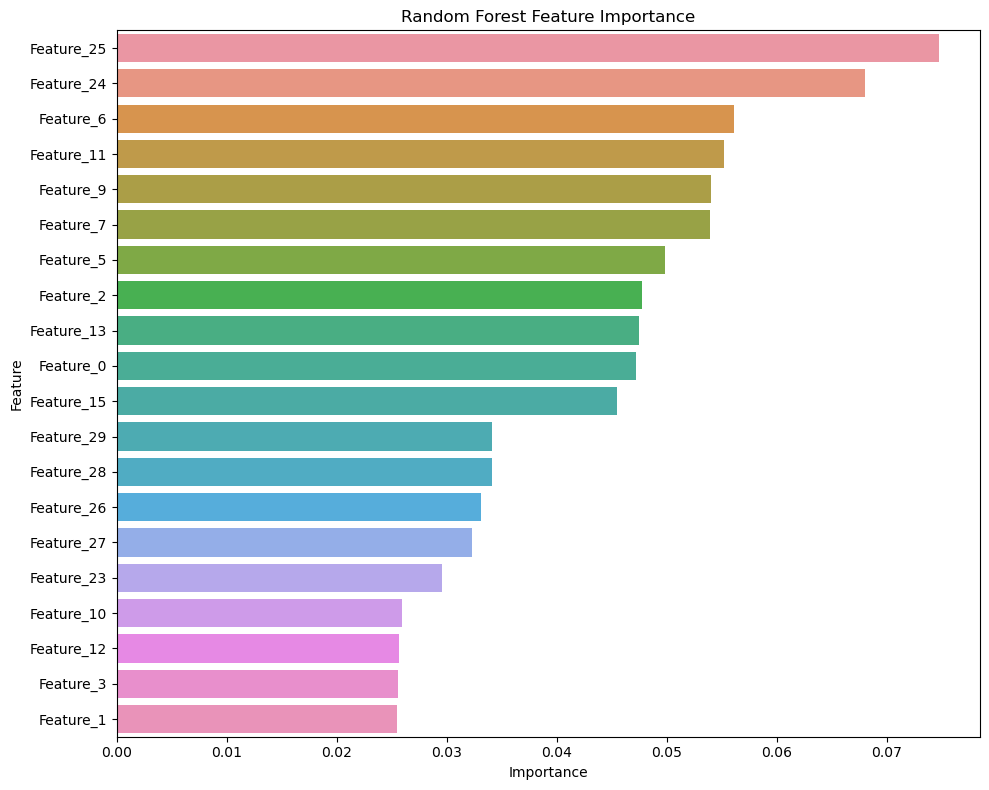

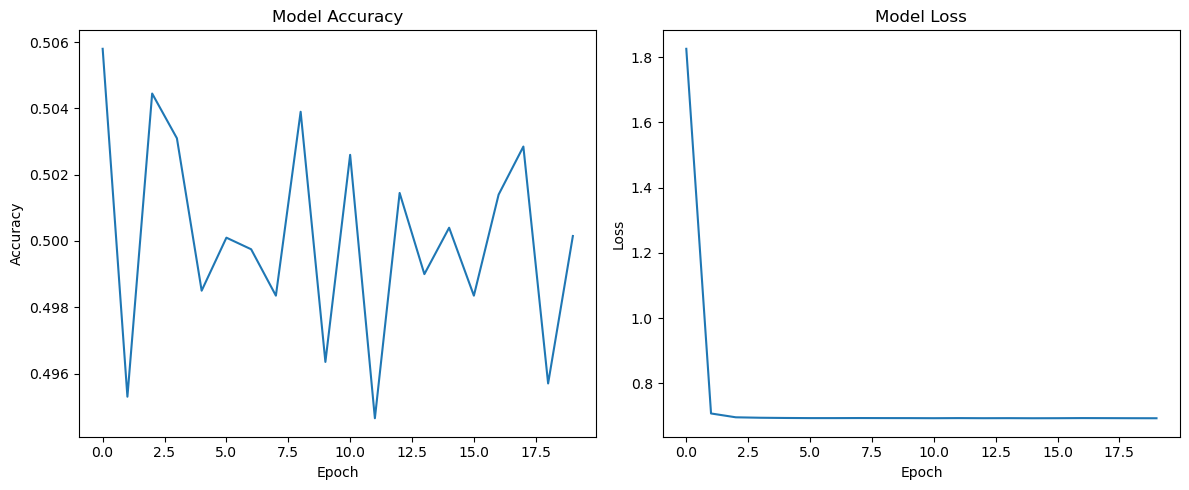

Win probability for ['Ah', 'Ks'] with ['7d', '8c', 'Th'] against 2 opponents: 0.19


C:\Users\ABI PRIYANKA\anaconda4\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Decision Engine Result:
Chosen action: bet_medium
Action probabilities: [0.22349881 0.06280524 0.33759043 0.28547838 0.09062714 0.        ]
Reasoning:
- Random Forest model suggests check/fold (confidence: 0.56)
- Neural Network model suggests check/fold (confidence: 0.50)
- CFR model suggests bet_medium (confidence: 0.79)
- RL agent suggests bet_large
- Final decision: bet_medium (confidence: 0.34)


C:\Users\ABI PRIYANKA\AppData\Local\Temp\ipykernel_28052\2495806563.py:319: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.monte_carlo and 'hole_cards' in hand_state and 'community_cards' in hand_state:


In [19]:
# Part 8: Opponent Modeling
class OpponentModeler:
    def __init__(self, n_players=6):
        """
        Initialize opponent modeling system
        
        Args:
            n_players: Number of opponents to model
        """
        self.n_players = n_players
        self.player_models = {}
        
        # Initialize models for each player
        for player_id in range(n_players):
            self.player_models[player_id] = {
                'vpip': [],  # Voluntarily put money in pot
                'pfr': [],   # Pre-flop raise
                'aggression_factor': [],  # (Bets + Raises) / Calls
                'fold_to_3bet': [],  # Fold to 3-bet percentage
                'fold_to_cbet': [],  # Fold to continuation bet
                'bluff_frequency': [],  # Estimated bluff frequency
                'action_history': []  # History of actions
            }
    
    def update_player_stats(self, player_id, hand_data):
        """Update statistics for a player based on observed hand"""
        if player_id not in self.player_models:
            return
        
        # Extract information from hand data
        vpip = hand_data.get('vpip', False)
        pfr = hand_data.get('pfr', False)
        bets = hand_data.get('bets', 0)
        raises = hand_data.get('raises', 0)
        calls = hand_data.get('calls', 0)
        fold_to_3bet = hand_data.get('fold_to_3bet', False)
        fold_to_cbet = hand_data.get('fold_to_cbet', False)
        actions = hand_data.get('actions', [])
        
        # Update player model
        if vpip is not None:
            self.player_models[player_id]['vpip'].append(int(vpip))
        if pfr is not None:
            self.player_models[player_id]['pfr'].append(int(pfr))
        
        # Calculate aggression factor if there were any actions
        if calls > 0:
            aggression_factor = (bets + raises) / calls
            self.player_models[player_id]['aggression_factor'].append(aggression_factor)
        
        if fold_to_3bet is not None:
            self.player_models[player_id]['fold_to_3bet'].append(int(fold_to_3bet))
        if fold_to_cbet is not None:
            self.player_models[player_id]['fold_to_cbet'].append(int(fold_to_cbet))
        
        # Add actions to history
        if actions:
            self.player_models[player_id]['action_history'].extend(actions)
    
    def estimate_bluff_frequency(self, player_id, recent_hands=50):
        """Estimate a player's bluffing frequency from shown-down hands"""
        if player_id not in self.player_models:
            return 0.5  # Default to 50% if no data
        
        # In a real implementation, this would analyze hands where the player 
        # bet or raised but had a weak hand at showdown
        # Here we just return a simplified estimate
        aggression = self.get_aggression_factor(player_id)
        pfr_pct = self.get_pfr(player_id)
        
        # Rough heuristic: players with high aggression and high PFR tend to bluff more
        bluff_estimate = min(0.8, (aggression * 0.1 + pfr_pct * 0.5))
        return max(0.1, bluff_estimate)  # Bound between 10% and 80%
    
    def get_vpip(self, player_id):
        """Get voluntarily put money in pot percentage"""
        if player_id not in self.player_models or not self.player_models[player_id]['vpip']:
            return 0.25  # Default value
        return sum(self.player_models[player_id]['vpip']) / len(self.player_models[player_id]['vpip'])
    
    def get_pfr(self, player_id):
        """Get pre-flop raise percentage"""
        if player_id not in self.player_models or not self.player_models[player_id]['pfr']:
            return 0.20  # Default value
        return sum(self.player_models[player_id]['pfr']) / len(self.player_models[player_id]['pfr'])
    
    def get_aggression_factor(self, player_id):
        """Get aggression factor"""
        if player_id not in self.player_models or not self.player_models[player_id]['aggression_factor']:
            return 1.5  # Default value
        return sum(self.player_models[player_id]['aggression_factor']) / len(self.player_models[player_id]['aggression_factor'])
    
    def get_fold_to_3bet(self, player_id):
        """Get fold to 3-bet percentage"""
        if player_id not in self.player_models or not self.player_models[player_id]['fold_to_3bet']:
            return 0.6  # Default value
        return sum(self.player_models[player_id]['fold_to_3bet']) / len(self.player_models[player_id]['fold_to_3bet'])
    
    def get_fold_to_cbet(self, player_id):
        """Get fold to continuation bet percentage"""
        if player_id not in self.player_models or not self.player_models[player_id]['fold_to_cbet']:
            return 0.5  # Default value
        return sum(self.player_models[player_id]['fold_to_cbet']) / len(self.player_models[player_id]['fold_to_cbet'])
    
    def categorize_opponent(self, player_id):
        """Categorize opponent playing style"""
        if player_id not in self.player_models:
            return "Unknown"
        
        vpip = self.get_vpip(player_id)
        pfr = self.get_pfr(player_id)
        aggression = self.get_aggression_factor(player_id)
        
        # Tight-Aggressive (TAG)
        if vpip < 0.25 and pfr > 0.15 and aggression > 2.0:
            return "TAG"
        
        # Loose-Aggressive (LAG)
        elif vpip > 0.35 and pfr > 0.25 and aggression > 2.0:
            return "LAG"
        
        # Tight-Passive (TP / Rock)
        elif vpip < 0.25 and pfr < 0.15 and aggression < 1.5:
            return "Rock"
        
        # Loose-Passive (LP / Calling Station)
        elif vpip > 0.35 and pfr < 0.25 and aggression < 1.5:
            return "Calling Station"
        
        # Maniac
        elif vpip > 0.45 and pfr > 0.35 and aggression > 3.0:
            return "Maniac"
        
        # Nit
        elif vpip < 0.15 and pfr < 0.10:
            return "Nit"
        
        # Average / Reg
        else:
            return "Regular"
    
    def get_exploitative_strategy(self, player_id):
        """Generate exploitative strategy recommendations against an opponent"""
        if player_id not in self.player_models:
            return ["Not enough data to generate exploitative strategy"]
        
        opponent_type = self.categorize_opponent(player_id)
        vpip = self.get_vpip(player_id)
        pfr = self.get_pfr(player_id)
        aggression = self.get_aggression_factor(player_id)
        fold_to_3bet = self.get_fold_to_3bet(player_id)
        fold_to_cbet = self.get_fold_to_cbet(player_id)
        
        recommendations = []
        
        # Generate recommendations based on opponent type
        if opponent_type == "TAG":
            recommendations.append("Tight-aggressive opponent. Respect their raises.")
            recommendations.append("Bluff less often as they're more likely to call with strong hands.")
            if fold_to_3bet > 0.7:
                recommendations.append("3-bet more liberally as they fold to 3-bets frequently.")
        
        elif opponent_type == "LAG":
            recommendations.append("Loose-aggressive opponent. They play many hands aggressively.")
            recommendations.append("Call down lighter as they're likely to bluff more frequently.")
            recommendations.append("Value bet thinner against them.")
        
        elif opponent_type == "Rock":
            recommendations.append("Tight-passive opponent. They play few hands and rarely raise.")
            recommendations.append("Bluff more often as they fold frequently.")
            recommendations.append("Avoid paying them off when they show aggression.")
        
        elif opponent_type == "Calling Station":
            recommendations.append("Loose-passive opponent. They call too much and don't raise enough.")
            recommendations.append("Value bet relentlessly and avoid bluffing.")
            recommendations.append("Size your value bets larger.")
        
        elif opponent_type == "Maniac":
            recommendations.append("Extremely aggressive opponent. They play many hands and raise frequently.")
            recommendations.append("Trap more often by checking strong hands.")
            recommendations.append("Call down much lighter as they bluff very frequently.")
        
        elif opponent_type == "Nit":
            recommendations.append("Extremely tight opponent. They play very few hands.")
            recommendations.append("Bluff liberally as they fold most hands.")
            recommendations.append("Fold to their raises as they rarely bluff.")
        
        # Add specific exploit recommendations
        if fold_to_cbet > 0.7:
            recommendations.append("C-bet more frequently as they fold to continuation bets often.")
        
        if aggression > 2.5:
            recommendations.append("Be cautious with medium-strength hands as they bet and raise frequently.")
        
        if vpip > 0.4 and pfr < 0.2:
            recommendations.append("Raise more pre-flop as they call too many hands.")
        
        return recommendations
    
    def save_models(self, filepath):
        """Save opponent models to disk"""
        with open(filepath, 'wb') as f:
            pickle.dump(self.player_models, f)
        print(f"Opponent models saved to {filepath}")
    
    def load_models(self, filepath):
        """Load opponent models from disk"""
        try:
            with open(filepath, 'rb') as f:
                self.player_models = pickle.load(f)
            print(f"Opponent models loaded from {filepath}")
        except FileNotFoundError:
            print(f"No opponent models found at {filepath}")


# Part 9: Decision Engine - Combining Models
class PokerDecisionEngine:
    def __init__(self, rf_model=None, nn_model=None, cfr_model=None, rl_agent=None, 
                 monte_carlo=None, opponent_modeler=None):
        """
        Initialize decision engine that combines different models
        
        Args:
            rf_model: Random Forest model
            nn_model: Neural Network model
            cfr_model: Counterfactual Regret Minimization model
            rl_agent: Reinforcement Learning agent
            monte_carlo: Monte Carlo simulator
            opponent_modeler: Opponent modeling system
        """
        self.rf_model = rf_model
        self.nn_model = nn_model
        self.cfr_model = cfr_model
        self.rl_agent = rl_agent
        self.monte_carlo = monte_carlo
        self.opponent_modeler = opponent_modeler
        
        # Action mapping
        self.action_map = {
            0: 'check/fold',
            1: 'bet_small',
            2: 'bet_medium',
            3: 'bet_large',
            4: 'raise',
            5: 'all_in'
        }
        
        # Default model weights
        self.model_weights = {
            'rf_model': 0.1,
            'nn_model': 0.2,
            'cfr_model': 0.3,
            'rl_agent': 0.2,
            'monte_carlo': 0.2,
            'opponent_model': 0.1
        }
    
    def set_model_weights(self, weights):
        """Set weights for each model in the ensemble"""
        self.model_weights = weights
        
        # Normalize weights to sum to 1
        total = sum(self.model_weights.values())
        for key in self.model_weights:
            self.model_weights[key] /= total
    
    def _extract_features(self, hand_state):
        """Extract features from the current hand state"""
        # In a real implementation, this would convert the hand state 
        # (cards, positions, etc.) into feature vectors for each model
        # Here we just assume hand_state is already a feature vector
        return hand_state
    
    def decide_action(self, hand_state, opponent_ids=None):
        """
        Decide the best action using ensemble of models
        
        Args:
            hand_state: Current state of the hand
            opponent_ids: IDs of opponents in the hand
            
        Returns:
            action: Decided action
            action_probs: Probability distribution over actions
            reasoning: Explanation for the decision
        """
        features = self._extract_features(hand_state)
        
        # Get predictions from each available model
        predictions = {}
        reasoning = []
        
        if self.rf_model:
            rf_probs = self.rf_model.predict_proba([features])[0]
            predictions['rf_model'] = rf_probs
            rf_action = np.argmax(rf_probs)
            reasoning.append(f"Random Forest model suggests {self.action_map[rf_action]} (confidence: {rf_probs[rf_action]:.2f})")
        
        if self.nn_model:
            nn_probs = self.nn_model.predict_proba(np.array([features]))[0]
            predictions['nn_model'] = nn_probs
            nn_action = np.argmax(nn_probs)
            reasoning.append(f"Neural Network model suggests {self.action_map[nn_action]} (confidence: {nn_probs[nn_action]:.2f})")
        
        if self.cfr_model:
            cfr_probs = self.cfr_model.get_strategy(features)
            predictions['cfr_model'] = cfr_probs
            cfr_action = np.argmax(cfr_probs)
            reasoning.append(f"CFR model suggests {self.action_map[cfr_action]} (confidence: {cfr_probs[cfr_action]:.2f})")
        
        if self.rl_agent:
            rl_action = self.rl_agent.act(features, training=False)
            # For RL, we don't have probabilities, so create one-hot
            rl_probs = np.zeros(len(self.action_map))
            rl_probs[rl_action] = 1.0
            predictions['rl_agent'] = rl_probs
            reasoning.append(f"RL agent suggests {self.action_map[rl_action]}")
        
        if self.monte_carlo and 'hole_cards' in hand_state and 'community_cards' in hand_state:
            # Get win probability from Monte Carlo simulation
            win_prob = self.monte_carlo.simulate_hand(
                hand_state['hole_cards'],
                hand_state['community_cards'],
                n_opponents=hand_state.get('n_opponents', 1)
            )
            
            # Convert win probability to action probabilities
            if win_prob < 0.3:  # Weak hand
                mc_probs = np.array([0.6, 0.3, 0.1, 0.0, 0.0, 0.0])  # Prefer folding
            elif win_prob < 0.5:  # Medium hand
                mc_probs = np.array([0.2, 0.4, 0.3, 0.1, 0.0, 0.0])  # Small bets
            elif win_prob < 0.7:  # Strong hand
                mc_probs = np.array([0.0, 0.1, 0.4, 0.3, 0.2, 0.0])  # Value bets
            else:  # Very strong hand
                mc_probs = np.array([0.0, 0.0, 0.1, 0.3, 0.4, 0.2])  # Aggressive
            
            predictions['monte_carlo'] = mc_probs
            reasoning.append(f"Monte Carlo estimates {win_prob:.2f} win probability")
        
        # Incorporate opponent modeling if available
        if self.opponent_modeler and opponent_ids:
            opponent_probs = np.zeros(len(self.action_map))
            
            for opp_id in opponent_ids:
                opp_type = self.opponent_modeler.categorize_opponent(opp_id)
                
                # Adjust strategy based on opponent type
                if opp_type == "Calling Station":
                    # Against calling stations, value bet more, bluff less
                    opponent_probs += np.array([0.1, 0.1, 0.3, 0.4, 0.1, 0.0])
                    reasoning.append(f"Opponent {opp_id} is a calling station - value bet more")
                
                elif opp_type == "Nit":
                    # Against nits, bluff more
                    opponent_probs += np.array([0.1, 0.3, 0.4, 0.2, 0.0, 0.0])
                    reasoning.append(f"Opponent {opp_id} is a nit - bluff more")
                
                elif opp_type == "TAG":
                    # Against TAGs, play more carefully
                    opponent_probs += np.array([0.3, 0.3, 0.2, 0.1, 0.1, 0.0])
                    reasoning.append(f"Opponent {opp_id} is TAG - play carefully")
                
                elif opp_type == "LAG":
                    # Against LAGs, call down lighter
                    opponent_probs += np.array([0.2, 0.1, 0.3, 0.2, 0.2, 0.0])
                    reasoning.append(f"Opponent {opp_id} is LAG - call down lighter")
                
                elif opp_type == "Maniac":
                    # Against maniacs, trap more
                    opponent_probs += np.array([0.4, 0.1, 0.1, 0.1, 0.2, 0.1])
                    reasoning.append(f"Opponent {opp_id} is a maniac - trap more")
            
            # Average across all opponents
            opponent_probs /= len(opponent_ids)
            predictions['opponent_model'] = opponent_probs
        
        # Combine all predictions with weights
        final_probs = np.zeros(len(self.action_map))
        for model, probs in predictions.items():
            weight = self.model_weights.get(model, 0)
            final_probs[: len(probs)] += probs * weight  # Only update matching elements
        
        # Normalize
        if np.sum(final_probs) > 0:
            final_probs /= np.sum(final_probs)
        
        # Choose action with highest probability
        action = np.argmax(final_probs)
        action_name = self.action_map[action]
        
        reasoning.append(f"Final decision: {action_name} (confidence: {final_probs[action]:.2f})")
        
        return action, final_probs, reasoning


# Part 10: Main Integration
def main():
    # Initialize dataset
    poker_data = PokerHandDataset()
    poker_data.load_data()
    X, y = poker_data.preprocess_data()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        poker_data.features, poker_data.labels, test_size=0.2, random_state=42
    )
    
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
    
    # Train Random Forest model
    rf_model = RandomForestPokerModel()
    rf_model.train(X_train, y_train)
    rf_cm = rf_model.evaluate(X_test, y_test)
    
    # Plot feature importance
    feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
    rf_model.plot_feature_importance(feature_names)
    
    # Train Neural Network model
    nn_model = NeuralNetworkPokerModel(input_dim=X_train.shape[1])
    history = nn_model.train(X_train, y_train, epochs=20)
    nn_cm = nn_model.evaluate(X_test, y_test)
    nn_model.plot_training_history(history)
    
    # Initialize hand evaluator
    hand_evaluator = PokerHandEvaluator()
    
    # Initialize Monte Carlo simulator
    mc_simulator = MonteCarloSimulator(hand_evaluator)
    
    # Example: estimate win probability for a hand
    hole_cards = ["Ah", "Ks"]
    community_cards = ["7d", "8c", "Th"]
    win_prob = mc_simulator.simulate_hand(
        hole_cards=hole_cards,
        community_cards=community_cards,
        n_opponents=2,
        n_simulations=1000
    )
    print(f"Win probability for {hole_cards} with {community_cards} against 2 opponents: {win_prob:.2f}")
    
    # Initialize Deep CFR model
    cfr_model = DeepCFR(input_dim=X_train.shape[1])
    
    # Initialize RL agent
    rl_agent = PokerRLAgent(state_dim=X_train.shape[1])
    
    # Initialize opponent modeler
    opponent_modeler = OpponentModeler()
    
    # Initialize decision engine
    decision_engine = PokerDecisionEngine(
        rf_model=rf_model,
        nn_model=nn_model,
        cfr_model=cfr_model,
        rl_agent=rl_agent,
        monte_carlo=mc_simulator,
        opponent_modeler=opponent_modeler
    )
    
    # Example: make a decision
    example_state = {
        'hole_cards': ["Ah", "Ks"],
        'community_cards': ["7d", "8c", "Th"],
        'position': 'BTN',
        'players_left': 2,
        'pot_size': 50,
        'stack_size': 500,
        'n_opponents': 2
    }
    
    # Convert to features (in real implementation, would use a proper feature extractor)
    example_features = X_test[0]  # Just use a test sample for demonstration
    
    action, probs, reasoning = decision_engine.decide_action(example_features)
    
    print("\nDecision Engine Result:")
    print(f"Chosen action: {decision_engine.action_map[action]}")
    print(f"Action probabilities: {probs}")
    print("Reasoning:")
    for reason in reasoning:
        print(f"- {reason}")


if __name__ == "__main__":
    main()